In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import KFold

In [7]:
!pip install -U gdown
!gdown 1P4E6cTn4X6rgK9SyOsMA344kLNyISPHQ
!unzip Phase1.zip

Downloading...
From (original): https://drive.google.com/uc?id=1P4E6cTn4X6rgK9SyOsMA344kLNyISPHQ
From (redirected): https://drive.google.com/uc?id=1P4E6cTn4X6rgK9SyOsMA344kLNyISPHQ&confirm=t&uuid=0f0c50f4-52c6-4f0b-aee1-dcdbf07cc4c0
To: /kaggle/working/Phase1.zip
100%|████████████████████████████████████████| 204M/204M [00:03<00:00, 61.5MB/s]
Archive:  Phase1.zip
   creating: DataSet1/
   creating: DataSet1/Defected/
  inflating: DataSet1/Defected/aug_gauss_noise_cast_def_0_737.jpeg  
  inflating: DataSet1/Defected/aug_gauss_noise_cast_def_0_966.jpeg  
  inflating: DataSet1/Defected/aug_gauss_noise_cast_def_0_1046.jpeg  
  inflating: DataSet1/Defected/aug_gauss_noise_cast_def_0_773.jpeg  
  inflating: DataSet1/Defected/aug_gauss_noise_cast_def_0_91.jpeg  
  inflating: DataSet1/Defected/aug_gauss_noise_cast_def_0_150.jpeg  
  inflating: DataSet1/Defected/aug_gauss_noise_cast_def_0_602.jpeg  
  inflating: DataSet1/Defected/aug_gauss_noise_cast_def_0_430.jpeg  
  inflating: DataSet1/Defec

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
in_channels = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 64
num_epochs = 10
k_folds = 5

In [5]:
def create_model():
    model = torchvision.models.efficientnet_v2_l(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = torch.nn.Identity()
    model.classifier = torch.nn.Linear(in_features=327680, out_features=1)
    model.to(device)
    return model

In [8]:
class DisksDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir='DataSet1', transform=None):
        defected_images_names = list(map(lambda x: os.path.join('Defected', x), os.listdir(os.path.join(root_dir, 'Defected'))))
        ok_images_names = list(map(lambda x: os.path.join('OK', x), os.listdir(os.path.join(root_dir, 'OK'))))
        self.annotations = pd.DataFrame({'img_name': defected_images_names + ok_images_names, 'label': [1]*len(defected_images_names) + [0]*len(ok_images_names)})
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(filename=img_path, flags=cv2.IMREAD_COLOR)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)
        return (image, y_label)

dataset = DisksDataset(transform=torchvision.transforms.ToTensor())
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [1000, 250])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
model = create_model()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:03<00:00, 144MB/s]  


In [10]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [11]:
train_acc = []
validation_acc = []

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, total=len(train_loader), leave=True)
    total_correct = 0
    total_samples = 0
    for data, targets in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        scores = model(data).reshape(-1)
        loss = criterion(scores, targets.float())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_correct += ((scores >= 0).float() == targets).sum().item()
        total_samples += scores.size(0)
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), train_acc=total_correct/total_samples)
    train_acc.append(total_correct/total_samples)

    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data).reshape(-1)
            total_correct += ((scores >= 0).float() == targets).sum().item()
            total_samples += scores.size(0)
        validation_acc.append(total_correct/total_samples)
        print(f"Validation Accuracy: {validation_acc[-1]}")

Epoch [1/10]: 100%|██████████| 16/16 [00:57<00:00,  3.58s/it, loss=5.91, train_acc=0.638]


Validation Accuracy: 0.8


Epoch [2/10]: 100%|██████████| 16/16 [00:58<00:00,  3.67s/it, loss=4, train_acc=0.815]   


Validation Accuracy: 0.816


Epoch [3/10]: 100%|██████████| 16/16 [00:58<00:00,  3.65s/it, loss=0.00788, train_acc=0.895]


Validation Accuracy: 0.912


Epoch [4/10]: 100%|██████████| 16/16 [00:58<00:00,  3.65s/it, loss=1.21, train_acc=0.955]  


Validation Accuracy: 0.896


Epoch [5/10]: 100%|██████████| 16/16 [00:58<00:00,  3.66s/it, loss=0.994, train_acc=0.961] 


Validation Accuracy: 0.924


Epoch [6/10]: 100%|██████████| 16/16 [00:58<00:00,  3.66s/it, loss=0.00016, train_acc=0.974]


Validation Accuracy: 0.92


Epoch [7/10]: 100%|██████████| 16/16 [00:58<00:00,  3.65s/it, loss=0.0327, train_acc=0.979] 


Validation Accuracy: 0.92


Epoch [8/10]: 100%|██████████| 16/16 [00:58<00:00,  3.66s/it, loss=0.294, train_acc=0.979]  


Validation Accuracy: 0.932


Epoch [9/10]: 100%|██████████| 16/16 [00:58<00:00,  3.64s/it, loss=0.274, train_acc=0.979] 


Validation Accuracy: 0.92


Epoch [10/10]: 100%|██████████| 16/16 [00:58<00:00,  3.64s/it, loss=0.0757, train_acc=0.978]  


Validation Accuracy: 0.932


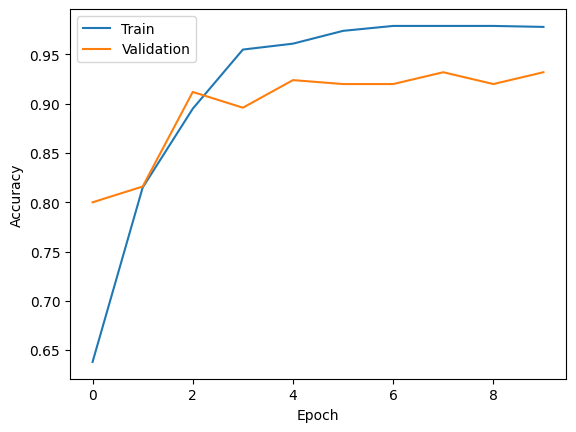

In [15]:
plt.plot(train_acc, label="Train")
plt.plot(validation_acc, label="Validation")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
from torchmetrics.functional.classification import binary_accuracy
from torchmetrics.functional.classification import binary_precision
from torchmetrics.functional.classification import binary_recall
from torchmetrics.functional.classification import binary_f1_score
from torchmetrics.functional.classification import binary_specificity
from torchmetrics.functional.classification import binary_auroc


def check_performance(loader, model):
    model.eval()
    full_y = torch.tensor([], device=device, dtype=torch.int8)
    full_predictions = torch.tensor([], device=device)
    full_scores = torch.tensor([], device=device)

    with torch.no_grad():
        for x, y in loader:

            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x).reshape(-1)
            predictions = (scores >= 0).float()
            full_y = torch.cat(tensors=(full_y, y))
            full_predictions = torch.cat(tensors=(full_predictions, predictions))
            full_scores = torch.cat(tensors=(full_scores, scores))
            

        accuracy = binary_accuracy(full_predictions, full_y)
        precision = binary_precision(full_predictions, full_y)
        recall = binary_recall(full_predictions, full_y)
        f1_score = binary_f1_score(full_predictions, full_y)
        specificity = binary_specificity(full_predictions, full_y)
        auroc = binary_auroc(full_scores, full_y)
    model.train()
    return accuracy, precision, recall, f1_score, specificity, auroc, full_y, full_predictions, full_scores

In [32]:
accuracy, precision, recall, f1_score, specificity, auroc, full_y, full_predictions, full_scores = check_performance(train_loader, model)
print(f"Accuracy: {accuracy:.4}\nPrecision: {precision:.4}\nRecall: {recall:.4}\nF1 score: {f1_score:.4}\nSpecificity: {specificity:.4}\nArea under the ROC: {auroc:.4}")

Accuracy: 0.998
Precision: 1.0
Recall: 0.9967
F1 score: 0.9984
Specificity: 1.0
Area under the ROC: 1.0


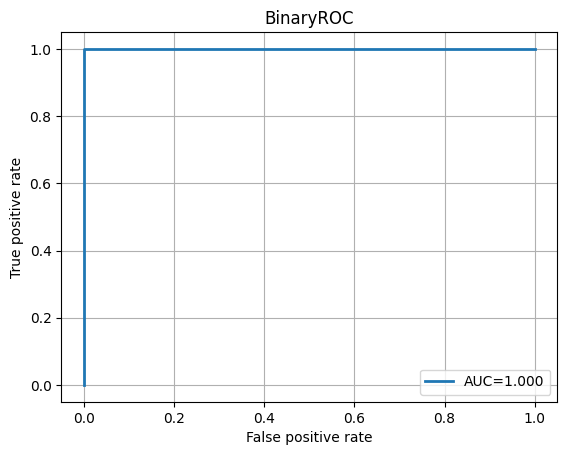

In [33]:
from torchmetrics.classification import BinaryROC
metric = BinaryROC()
metric.update(full_scores, full_y)
fig_, ax_ = metric.plot(score=True)

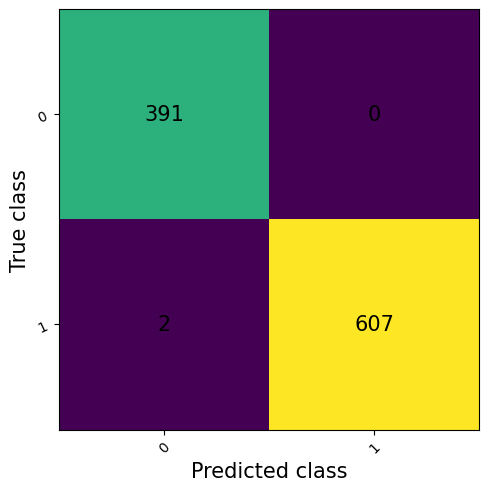

In [34]:
from torchmetrics.classification import BinaryConfusionMatrix
metric = BinaryConfusionMatrix().to(device)
metric.update(full_predictions, full_y)
fig_, ax_ = metric.plot()

In [35]:
accuracy, precision, recall, f1_score, specificity, auroc, full_y, full_predictions, full_scores = check_performance(test_loader, model)
print(f"Accuracy: {accuracy:.4}\nPrecision: {precision:.4}\nRecall: {recall:.4}\nF1 score: {f1_score:.4}\nSpecificity: {specificity:.4}\nArea under the ROC: {auroc:.4}")

Accuracy: 0.932
Precision: 0.9844
Recall: 0.8936
F1 score: 0.9368
Specificity: 0.9817
Area under the ROC: 0.9843


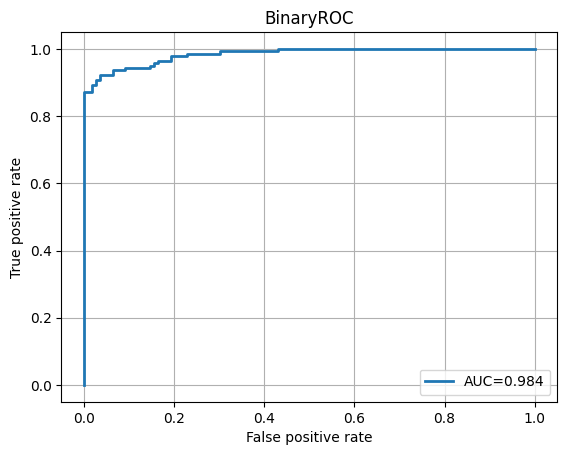

In [36]:
from torchmetrics.classification import BinaryROC
metric = BinaryROC()
metric.update(full_scores, full_y)
fig_, ax_ = metric.plot(score=True)

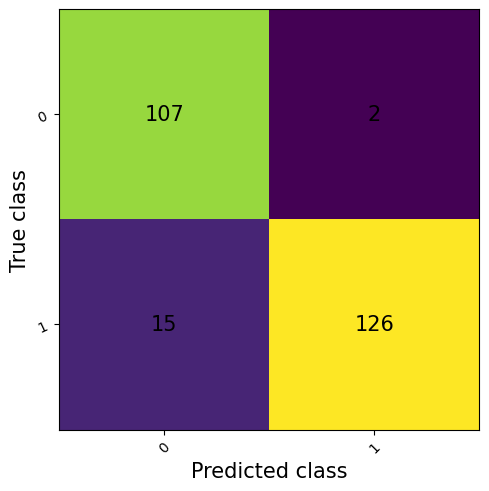

In [37]:
from torchmetrics.classification import BinaryConfusionMatrix
metric = BinaryConfusionMatrix().to(device)
metric.update(full_predictions, full_y)
fig_, ax_ = metric.plot()

In [ ]:
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")

    train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_idx))
    test_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(test_idx))

    model = create_model()
    model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total=len(train_loader), leave=True)
        for data, targets in loop:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data).reshape(-1)
            loss = criterion(scores, targets.float())

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

    print(f"Test set: ", end='')
    accuracy, precision, recall, f1_score, specificity, auroc, full_y, full_predictions, full_scores = check_performance(test_loader, model)
    print(f"Accuracy: {accuracy:.4}, Precision: {precision:.4}, Recall: {recall:.4}, F1 score: {f1_score:.4}, Specificity: {specificity:.4}, Area under the ROC: {auroc:.4}")

Fold 1

-------


Epoch [1/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/it, loss=1.55]

Epoch [2/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01it/s, loss=1.66]

Epoch [3/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01it/s, loss=2.39]

Epoch [4/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01it/s, loss=1.18]

Epoch [5/10]: 100%|██████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01it/s, loss=5.59e-7]

Epoch [6/10]: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01it/s, loss=0.406]

Epoch [7/10]: 100%|███████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01it/s, loss=0.0601]

Epoch [8/10]: 100%|██████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.01it/s, loss=1.56e-6]

Epoch [9/10]: 100%|█████████████

Test set: Got 188 / 200 with accuracy 94.00

Fold 2

-------


Epoch [1/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/it, loss=2.59]

Epoch [2/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/it, loss=2.25]

Epoch [3/10]: 100%|██████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.03s/it, loss=0.00105]

Epoch [4/10]: 100%|██████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/it, loss=4.69e-7]

Epoch [5/10]: 100%|████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/it, loss=0]

Epoch [6/10]: 100%|██████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00it/s, loss=0.00243]

Epoch [7/10]: 100%|████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/it, loss=0]

Epoch [8/10]: 100%|████████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00it/s, loss=0]

Epoch [9/10]: 100%|█████████████

Test set: Got 184 / 200 with accuracy 92.00

Fold 3

-------


Epoch [1/10]: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=0.522]

Epoch [2/10]: 100%|█████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=0.000854]

Epoch [3/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=2.71]

Epoch [4/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=1.41]

Epoch [5/10]: 100%|████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/it, loss=0]

Epoch [6/10]: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=0.0119]

Epoch [7/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/it, loss=2.25]

Epoch [8/10]: 100%|██████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/it, loss=1.68e-7]

Epoch [9/10]: 100%|█████████████

Test set: Got 187 / 200 with accuracy 93.50

Fold 4

-------


Epoch [1/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=1.98]

Epoch [2/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=0.17]

Epoch [3/10]: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00it/s, loss=0.312]

Epoch [4/10]: 100%|███████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/it, loss=0.0186]

Epoch [5/10]: 100%|████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=0.695]

Epoch [6/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=0.31]

Epoch [7/10]: 100%|████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=0]

Epoch [8/10]: 100%|██████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=1.12e-8]

Epoch [9/10]: 100%|█████████████

Test set: Got 189 / 200 with accuracy 94.50

Fold 5

-------


Epoch [1/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/it, loss=16.7]

Epoch [2/10]: 100%|██████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00it/s, loss=3.5]

Epoch [3/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00it/s, loss=1.04]

Epoch [4/10]: 100%|██████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/it, loss=5.63e-7]

Epoch [5/10]: 100%|████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00it/s, loss=0.299]

Epoch [6/10]: 100%|████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/it, loss=0]

Epoch [7/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.01s/it, loss=1.01]

Epoch [8/10]: 100%|█████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.00it/s, loss=1.05]

Epoch [9/10]: 100%|█████████████

Test set: Got 191 / 200 with accuracy 95.50
